In [1]:
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser
import sklearn
from datetime import datetime
from model_architecture import define_model

Using TensorFlow backend.


In [2]:
data = pd.read_csv('./assignment20200701/MD (2010-2020)/MD from 2010 to 2020/AUDUSD.csv')

In [3]:
data.head()

,Time (UTC),Open,High,Low,Close,Volume
0,2010.01.01 02:00:00,0.89748,0.89759,0.89741,0.89747,7951.85
1,2010.01.01 06:00:00,0.89747,0.89763,0.89739,0.89754,18505.45
2,2010.01.01 10:00:00,0.89755,0.89763,0.89746,0.89750,15265.53
3,2010.01.01 14:00:00,0.89753,0.89769,0.89746,0.89753,16587.97
4,2010.01.01 18:00:00,0.89755,0.89765,0.89738,0.89738,7615.19


In [4]:
## change variable type of 'Time (UTC)' from string to datetime
data['Time (UTC)'] = data["Time (UTC)"].apply(lambda x: parser.parse(x))

In [5]:
data.dtypes

Time (UTC)    datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
dtype: object

In [6]:
def directional_accuracy(y_test,model_output):
    output=[]
    for i in range(1,len(model_output)):
        if np.sign(y_test[i]-y_test[i-1])==0:
            output.append(1.000)
        else:
            output.append((np.sign(model_output[i]-y_test[i-1])==np.sign(y_test[i]-y_test[i-1])).astype(int))
    accuracy = np.mean(np.array(output))
    print('directional accuracy  = ',accuracy)
    
def percentage_Absolute_Error(y_test,model_output):
    positive=[]
    negative=[]
    for i in range(1,len(model_output)):
        if np.sign(y_test[i]-y_test[i-1])==0:
            positive.append(0)
        elif (model_output[i]- y_test[i]) >0 :
            positive.append((model_output[i]- y_test[i])/np.abs(y_test[i-1]-y_test[i]))
        else:
            negative.append((model_output[i]- y_test[i])/np.abs(y_test[i-1]-y_test[i]))
    positive_perc_abs_error = np.mean(np.array(positive))
    negative_perc_abs_error = np.mean(np.array(negative))
    print('positive percentage Absolute Error = ',positive_perc_abs_error)
    print('negative percentage Absolute Error = ',negative_perc_abs_error)

### feature engenering

In [7]:
## extract hour from the timestep
def hour(x):
    d = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    return d.hour

data['Hour'] = data["Time (UTC)"].apply(lambda x: hour(x))


## extract weekday from the timestep variable
def weekday(x):
    d = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').weekday()
    return d
data['weekday'] = data["Time (UTC)"].apply(lambda x: weekday(x))

In [8]:
## drop time variable
data = data.drop(['Time (UTC)'],axis=1)
data.head()

,Open,High,Low,Close,Volume,Hour,weekday
0,0.89748,0.89759,0.89741,0.89747,7951.85,2,4
1,0.89747,0.89763,0.89739,0.89754,18505.45,6,4
2,0.89755,0.89763,0.89746,0.89750,15265.53,10,4
3,0.89753,0.89769,0.89746,0.89753,16587.97,14,4
4,0.89755,0.89765,0.89738,0.89738,7615.19,18,4


In [9]:
## shift target variable at the last 
data2=data['High']
data = data.drop(['High'],axis=1)
data = pd.concat([data,data2],axis=1)
data.head()

,Open,Low,Close,Volume,Hour,weekday,High
0,0.89748,0.89741,0.89747,7951.85,2,4,0.89759
1,0.89747,0.89739,0.89754,18505.45,6,4,0.89763
2,0.89755,0.89746,0.89750,15265.53,10,4,0.89763
3,0.89753,0.89746,0.89753,16587.97,14,4,0.89769
4,0.89755,0.89738,0.89738,7615.19,18,4,0.89765


In [10]:
def load_data(data):
    data = data.values
    train = data[:13200,:]
    test = data[13200:,:]

    ## split into input and output
    X_train, y_train = train[:,:-1] , train[:,-1]
    X_test, y_test = test[:,:-1] , test[:,-1]
    
    ## reshape data
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)    
    return X_train, y_train, X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = load_data(data)

(13200, 6, 1) (13200,) (2700, 6, 1) (2700,)


### model training with mape loss 

In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

In [48]:
model = define_model(X_train,loss='mape')
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (20, 6, 1)           0                                            
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (20, 6, 5)           15          input_22[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_22 (MaxPooling1D) (20, 3, 5)           0           conv1d_22[0][0]                  
__________________________________________________________________________________________________
dropout_22 (Dropout)            (20, 3, 5)           0           max_pooling1d_22[0][0]           
____________________________________________________________________________________________

In [49]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=7,verbose=1,mode='min',restore_best_weights=True)
mcp_save = ModelCheckpoint('.mape_mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

### train the model on train data with adam optimiser and mape loss function
model.fit([X_train,X_train,X_train], y_train, validation_data=([X_test,X_test,X_test],y_test), epochs=200, batch_size=20, callbacks=[earlystopping, mcp_save, reduce_lr_loss])

Train on 13200 samples, validate on 2700 samples
Epoch 1/200
13200/13200 [==============================] - 35s 3ms/step - loss: 10.0380 - val_loss: 19.9644
Epoch 2/200
13200/13200 [==============================] - 29s 2ms/step - loss: 2.5813 - val_loss: 0.8481
Epoch 3/200
13200/13200 [==============================] - 29s 2ms/step - loss: 1.5327 - val_loss: 3.8235
Epoch 4/200
13200/13200 [==============================] - 30s 2ms/step - loss: 1.8249 - val_loss: 2.2088
Epoch 5/200
13200/13200 [==============================] - 30s 2ms/step - loss: 1.3550 - val_loss: 1.3640oss: - ETA: 0s -
Epoch 6/200
13200/13200 [==============================] - 29s 2ms/step - loss: 0.9793 - val_loss: 1.3532
Epoch 7/200
13200/13200 [==============================] - 30s 2ms/step - loss: 0.9649 - val_loss: 0.5575
Epoch 8/200
13200/13200 [==============================] - 30s 2ms/step - loss: 1.0003 - val_loss: 1.0592
Epoch 9/200
13200/13200 [==============================] - 29s 2ms/step - loss: 0.917

In [43]:
## predict for the test data
model_output = model.predict([X_test,X_test,X_test],batch_size=20)

model_score = r2_score(y_test,model_output)
print("R^2 Score of model = ",model_score)

R^2 Score of model =  0.99459696799173


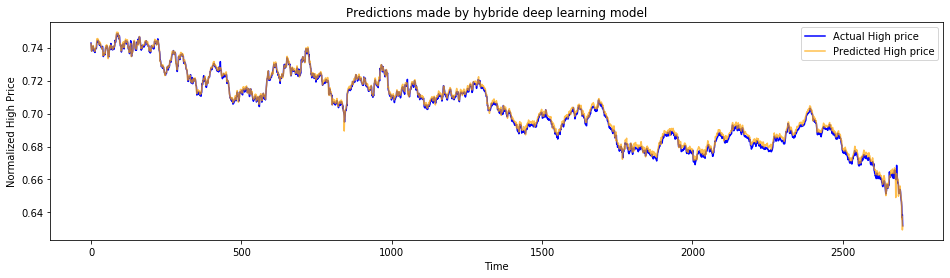

In [44]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual High price')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted High price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized High Price')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, model_output, "Predictions made by hybride deep learning model")

In [45]:
model_output = np.round(model_output,4)

## directional accuracy
directional_accuracy(y_test,model_output)

### percentage absolute error
percentage_Absolute_Error(y_test,model_output)

directional accuracy  =  [0.64912931]
positive percentage Absolute Error =  [7.718214]
negative percentage Absolute Error =  -3.0911863


In [19]:
model.save('./mape_final_model_v1.h5')

### model training with mse loss 

In [20]:
model = define_model(X_train,loss='mse')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (20, 6, 1)           0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (20, 6, 5)           15          input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (20, 3, 5)           0           conv1d_4[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (20, 3, 5)           0           max_pooling1d_4[0][0]            
____________________________________________________________________________________________

In [21]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=7,verbose=1,mode='min',restore_best_weights=True)
mcp_save = ModelCheckpoint('.mse_mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

### train the model on train data with adam optimiser and mape loss function
model.fit([X_train,X_train,X_train], y_train, validation_data=([X_test,X_test,X_test],y_test), epochs=50, batch_size=20, callbacks=[earlystopping, mcp_save, reduce_lr_loss])

Train on 13200 samples, validate on 2700 samples
Epoch 1/50
13200/13200 [==============================] - 33s 3ms/step - loss: 0.0120 - val_loss: 1.5714e-04
Epoch 2/50
13200/13200 [==============================] - 27s 2ms/step - loss: 3.6003e-04 - val_loss: 4.2133e-04
Epoch 3/50
13200/13200 [==============================] - 27s 2ms/step - loss: 2.0222e-04 - val_loss: 1.7056e-04
Epoch 4/50
13200/13200 [==============================] - 27s 2ms/step - loss: 1.7583e-04 - val_loss: 0.0011
Epoch 5/50
13200/13200 [==============================] - 28s 2ms/step - loss: 1.5036e-04 - val_loss: 1.8746e-04
Epoch 6/50
13200/13200 [==============================] - 29s 2ms/step - loss: 6.7360e-05 - val_loss: 4.3143e-04

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
13200/13200 [==============================] - 30s 2ms/step - loss: 1.4596e-05 - val_loss: 5.0853e-06
Epoch 8/50
13200/13200 [==============================] - 28s 2ms/step - loss: 1.0343e

In [22]:
## predict for the test data
model_output = model.predict([X_test,X_test,X_test],batch_size=20)

model_score = r2_score(y_test,model_output)
print("R^2 Score of model = ",model_score) 

R^2 Score of model =  0.9929618860639031


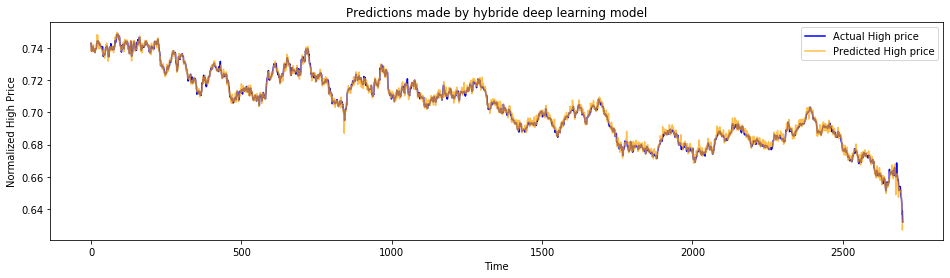

In [23]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual High price')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted High price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized High Price')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, model_output, "Predictions made by hybride deep learning model")

In [24]:
model_output = np.round(model_output,4)

## directional accuracy
directional_accuracy(y_test,model_output)

### percentage absolute error
percentage_Absolute_Error(y_test,model_output)

directional accuracy  =  [0.6683957]
positive percentage Absolute Error =  [8.181583]
negative percentage Absolute Error =  -5.124109


In [26]:
model.save('./mse_final_model_v1.h5')